# Pride & Prejudice analysis

# Real text analysis

We got familiar with Spacy. In the next section we are going to analyse a real text (Pride & Prejudice). 

We would like to:
* Extract the names of all the characters from the book (e.g. Elizabeth, Darcy, Bingley)
* Visualize characters' occurences with regards to relative position in the book
* Authomatically describe any character from the book
* Find out which characters have been mentioned in a context of marriage
* Build keywords extraction that could be used to display a word cloud ([example](http://www.cytora.com/data-samples.html))

## Load text file

In [4]:
def read_file(file_name):
    with open(file_name, 'r') as file:
        return file.read()  #.decode('utf-8')

## Process full text

In [5]:
import spacy

nlp = spacy.load('en')

# Process `text` with Spacy NLP Parser
text = read_file('data/pride_and_prejudice.txt')
processed_text = nlp(text)

In [6]:
# How many sentences are in the book (Pride & Prejudice)?
sentences = [s for s in processed_text.sents]
print(len(sentences))

# Print sentences from index 10 to index 15, to make sure that we have parsed the correct book
print(sentences[10:15])

5464
["What is his name?"

"Bingley."

, "Is he married or single?"

"Oh!, Single, my dear, to be sure!, A single man of large fortune; four or
five thousand a year., What a fine thing for our girls!"

]


## Find all the personal names

In [ ]:
# Extract all the personal names from Pride & Prejudice and count their occurrences. 
# Expected output is a list in the following form: [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266) ...].

from collections import Counter, defaultdict

def find_character_occurences(doc):
    """
    Return a list of actors from `doc` with corresponding occurences.
    
    :param doc: Spacy NLP parsed document
    :return: list of tuples in form
        [('elizabeth', 622), ('darcy', 312), ('jane', 286), ('bennet', 266)]
    """
    
    characters = Counter()
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            characters[ent.lemma_] += 1
            
    return characters.most_common()

In [11]:
[n for n in find_character_occurences(processed_text)[:20] if n[0]]

[('elizabeth', 608),
 ('darcy', 288),
 ('jane', 286),
 ('bennet', 248),
 ('wickham', 179),
 ('collins', 175),
 ('bingley', 166),
 ('lydia', 160),
 ('lizzy', 92),
 ('gardiner', 91),
 ('lady catherine', 71),
 ('kitty', 69),
 ('mary', 36),
 ('hurst', 32),
 ('phillips', 30),
 ('miss bingley', 30),
 ('catherine', 24),
 ('longbourn', 24),
 ('forster', 22)]

## Plot characters personal names as a time series 

In [12]:
# Matplotlib Jupyter HACK
%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [13]:
# Plot characters' mentions as a time series relative to the position of the actor's occurrence in a book.

def get_character_offsets(doc):
    """
    For every character in a `doc` collect all the occurences offsets and store them into a list. 
    The function returns a dictionary that has actor lemma as a key and list of occurences as a value for every character.
    
    :param doc: Spacy NLP parsed document
    :return: dict object in form
        {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    """
    
    character_offsets = defaultdict(list)
    for ent in doc.ents:
        if ent.label_ == 'PERSON':
            character_offsets[ent.lemma_].append(ent.start)
            
    return dict(character_offsets)

character_occurences = get_character_offsets(processed_text)

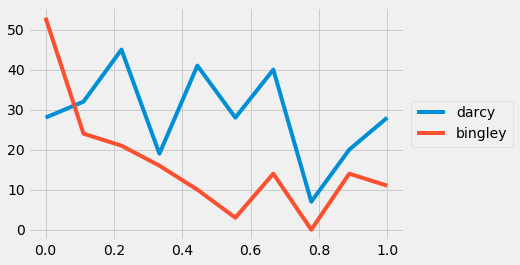

In [14]:
from matplotlib.pyplot import hist
from cycler import cycler

NUM_BINS = 10

def normalize(occurencies, normalization_constant):
    return [o / float(len(processed_text)) for o in occurencies]

def plot_character_timeseries(character_offsets, character_labels, normalization_constant=None):
    """
    Plot characters' personal names specified in `character_labels` list as time series.
    
    :param character_offsets: dict object in form {'elizabeth': [123, 543, 4534], 'darcy': [205, 2111]}
    :param character_labels: list of strings that should match some of the keys in `character_offsets`
    :param normalization_constant: int
    """
    x = [character_offsets[character_label] for character_label in character_labels] 
        
    with plt.style.context('fivethirtyeight'):
        plt.figure()
        n, bins, patches = plt.hist(x, NUM_BINS, label=character_labels)
        plt.clf()
        
        ax = plt.subplot(111)
        for i, a in enumerate(n):
            ax.plot([float(x) / (NUM_BINS - 1) for x in range(len(a))], a, label=character_labels[i])
            
        matplotlib.rcParams['axes.prop_cycle'] = cycler(color=['r','k','c','b','y','m','g','#54a1FF'])
        ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

#plot_character_timeseries(character_occurences, ['darcy', 'bingley'], normalization_constant=len(processed_text))
plot_character_timeseries(character_occurences, ['darcy', 'bingley'])

## Spacy parse tree in action

In [16]:
# Find words (adjectives) that describe Mr. Darcy.

def get_character_adjectives(doc, character_lemma):
    """
    Find all the adjectives related to `character_lemma` in `doc`
    
    :param doc: Spacy NLP parsed document
    :param character_lemma: string object
    :return: list of adjectives related to `character_lemma`
    """
    
    adjectives = []
    for ent in processed_text.ents:
        if ent.lemma_ == character_lemma:
            for token in ent.subtree:
                if token.pos_ == 'ADJ': # Replace with if token.dep_ == 'amod':
                    adjectives.append(token.lemma_)
    
    for ent in processed_text.ents:
        if ent.lemma_ == character_lemma:
            if ent.root.dep_ == 'nsubj':
                for child in ent.root.head.children:
                    if child.dep_ == 'acomp':
                        adjectives.append(child.lemma_)
    
    return adjectives

ch_adjs = get_character_adjectives(processed_text, 'darcy')

In [20]:
ch_adjs = list(set(ch_adjs))  # dedup
ch_adjs = sorted([c for c in ch_adjs if not ('-' in c or '_' in c)])
ch_adjs

['abominable',
 'all',
 'answerable',
 'ashamed',
 'bad',
 'bewitch',
 'clever',
 'confidential',
 'dear',
 'deficient',
 'delighted',
 'disappointing',
 'eld',
 'engaged',
 'equal',
 'few',
 'fond',
 'good',
 'grave',
 'handsome',
 'heightened',
 'impatient',
 'intimate',
 'last',
 'late',
 'little',
 'many',
 'much',
 'natured',
 'opposite',
 'own',
 'poor',
 'present',
 'proud',
 'punctual',
 'same',
 'selfish',
 'sensible',
 'studious',
 'such',
 'superior',
 'sure',
 'surprised',
 'tall',
 'that',
 'tranquil',
 'true',
 'unappeasable',
 'unwilling',
 'unworthy',
 'which',
 'whose',
 'worth',
 'wretched']

In [21]:
# Find characters that are 'talking', 'saying', 'doing' the most. Find the relationship between 
# entities and corresponding root verbs.

character_verb_counter = Counter()
VERB_LEMMA = 'say'

for ent in processed_text.ents:
    if ent.label_ == 'PERSON' and ent.root.head.lemma_ == VERB_LEMMA:
        character_verb_counter[ent.text] += 1

character_verb_counter.most_common(10)
        
# Find all the characters that got married in the book.
#
# Here is an example sentence from which this information could be extracted:
# 
# "her mother was talking to that one person (Lady Lucas) freely,
# openly, and of nothing else but her expectation that Jane would soon
# be married to Mr. Bingley."
#


[('Elizabeth', 40),
 ('Bennet', 27),
 ('Jane', 15),
 ('Miss Bingley', 7),
 ('Gardiner', 5),
 ('Lydia', 5),
 ('Darcy', 4),
 ('Wickham', 4),
 ('Lady Catherine', 4),
 ('Collins', 4)]

## Extract Keywords

In [22]:
# Extract Keywords using noun chunks from the news article (file 'article.txt').
# Spacy will pick some noun chunks that are not informative at all (e.g. we, what, who).
# Try to find a way to remove non informative keywords.

article = read_file('data/article.txt')
doc = nlp(article)

keywords = Counter()
for chunk in doc.noun_chunks:
    if nlp.vocab[chunk.lemma_].prob < - 8: # probablity value -8 is arbitrarily selected threshold
        keywords[chunk.lemma_] += 1

keywords.most_common(20)

[('-PRON-', 16),
 ('terrorism', 3),
 ('al - qaeda', 3),
 ('many country', 2),
 ('the ministry', 2),
 ('the responsibility', 2),
 ('interior', 2),
 ('social medium', 2),
 ('religion', 2),
 ('daesh', 2),
 ('saudi arabia', 2),
 ('excommunication', 2),
 ('god', 1),
 ('tyrant', 1),
 ('discussion', 1),
 ('-PRON- ideology', 1),
 ('the emergence', 1),
 ('the youth', 1),
 ('security expertise', 1),
 ('such a discourse', 1)]